Start the installs before you start reading -- you know -- for efficiency

In [1]:
%pip install qiskit qiskit-ibm-runtime qiskit-aer
!pip install pylatexenc matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 17.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━

# Quantum Phase Estimation

* Learn about Quantum Phase Estimation and how it is built out of a QFT
* Implement the QPE onto real hardware

These exercises are based on a mild concatenation of https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html and https://qiskit.org/textbook/ch-demos/piday-code.html

Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms, including Shor's algorithm, HHL for solving linear systems, and simulating particle collisions. The objective of the algorithm is the following:

Given a unitary operator $U$ and its eigenvector $|\psi\rangle$ with eigenvalue $e^{\boldsymbol{2\pi i}\theta}$ prepared in a register, the algorithm estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$.  For simple $U$ from which we can derive $|\psi\rangle$, this might not seem very useful, but for complicated $U$ where $|\psi\rangle$ is hard to determine, this can be an amazing ability.

How is this amazing?

An important question for high energy theories is "what is the energy of a bound state of quarks and gluons?"  As you might recall, this corresponds to find the energy eigenvalue of specific states of the Hamiltonian.  This is classically a hard problem to solve efficiently.  So how in practice do we use QPE to get this value?  A standard method would be to use the Hamiltonian to evolve the qubits in the $|\psi\rangle$ register with a state preparation algorithm into the desired quantum state.  Such state prcontainseparation algorithms can be done despite the user not knowing how to prepare the state themself.  Once you have that state, one need only apply the QPE to that state to learn the energy of the previously unknown state.

The general quantum circuit for phase estimation is shown below. The top register contains $t$ 'counting' qubits, and the bottom contains qubits in the state $|\psi\rangle$:

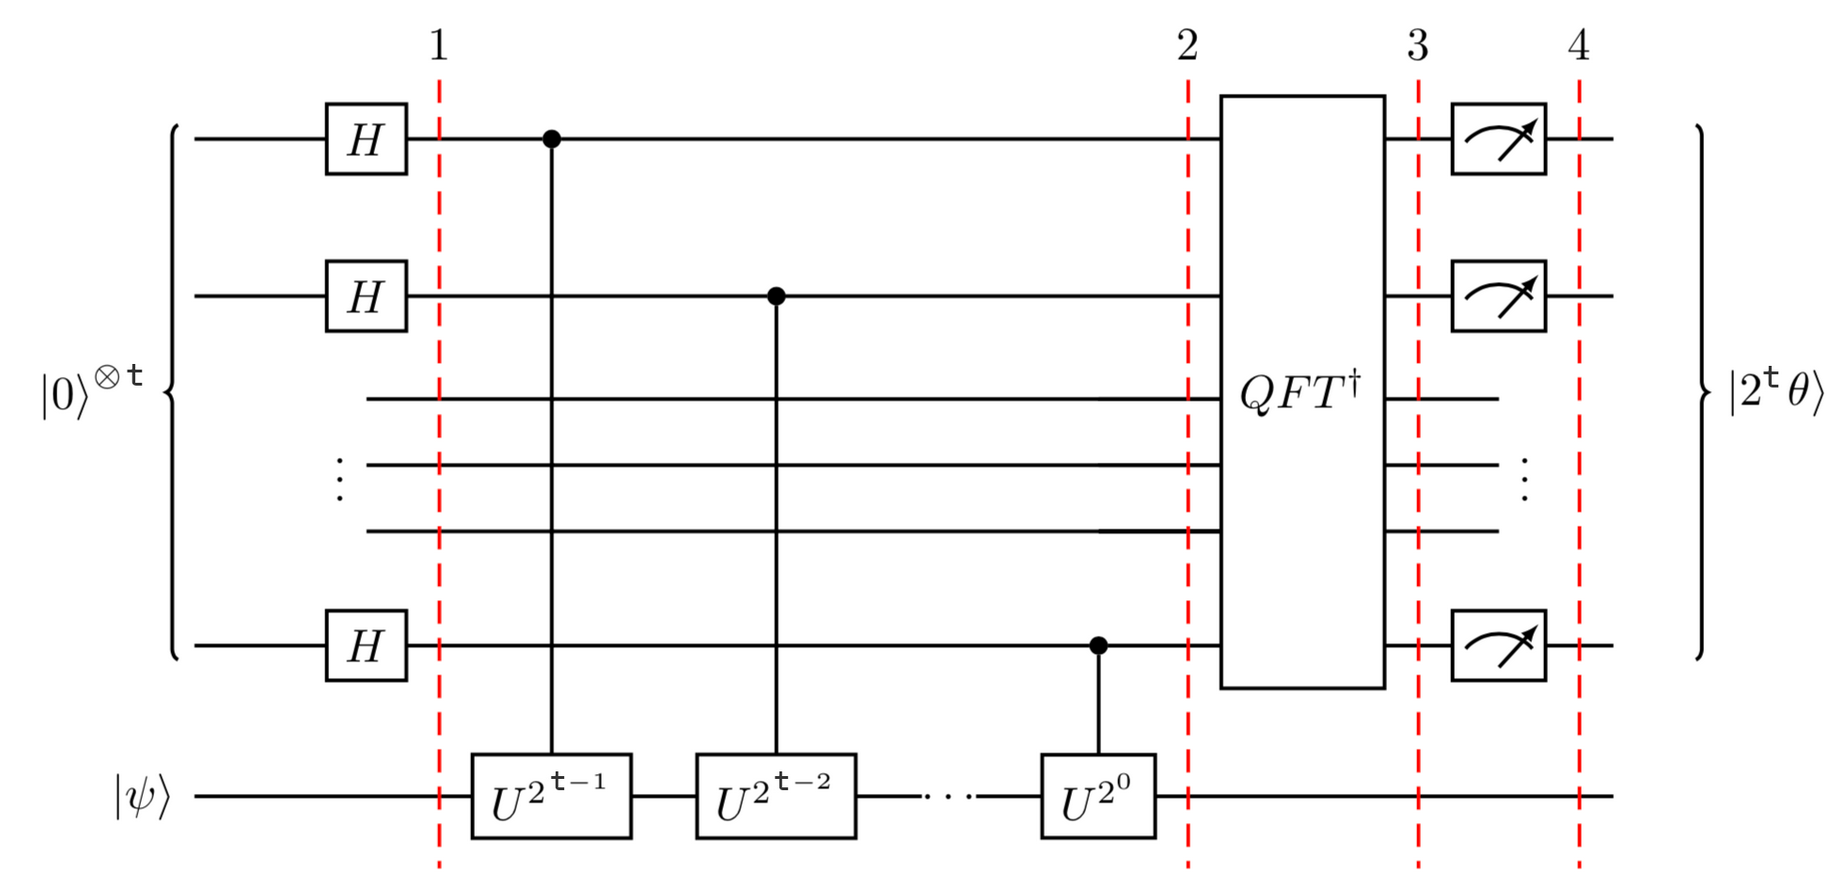

## Intuition <a id='intuition'></a>
The quantum phase estimation (QPE) algorithm uses phase kickback (When a gate acting on a state returns the same state, but with a different phase) to write the phase of $U$ (in the Fourier basis) to the $t$ qubits in the counting register. We use $U_{QFT}^{\dagger}$ to translate this from the Fourier basis into the computational basis, which we can then measure.

Hopefully, you recall that in the Fourier basis, the topmost qubit completes one full rotation when counting between $0$ and $2^t$. To count to a number, $x$ between $0$ and $2^t$, we rotate this qubit by $\tfrac{x}{2^t}$ around the z-axis. For the next qubit we rotate by $\tfrac{2x}{2^t}$, then $\tfrac{4x}{2^t}$ for the third qubit.

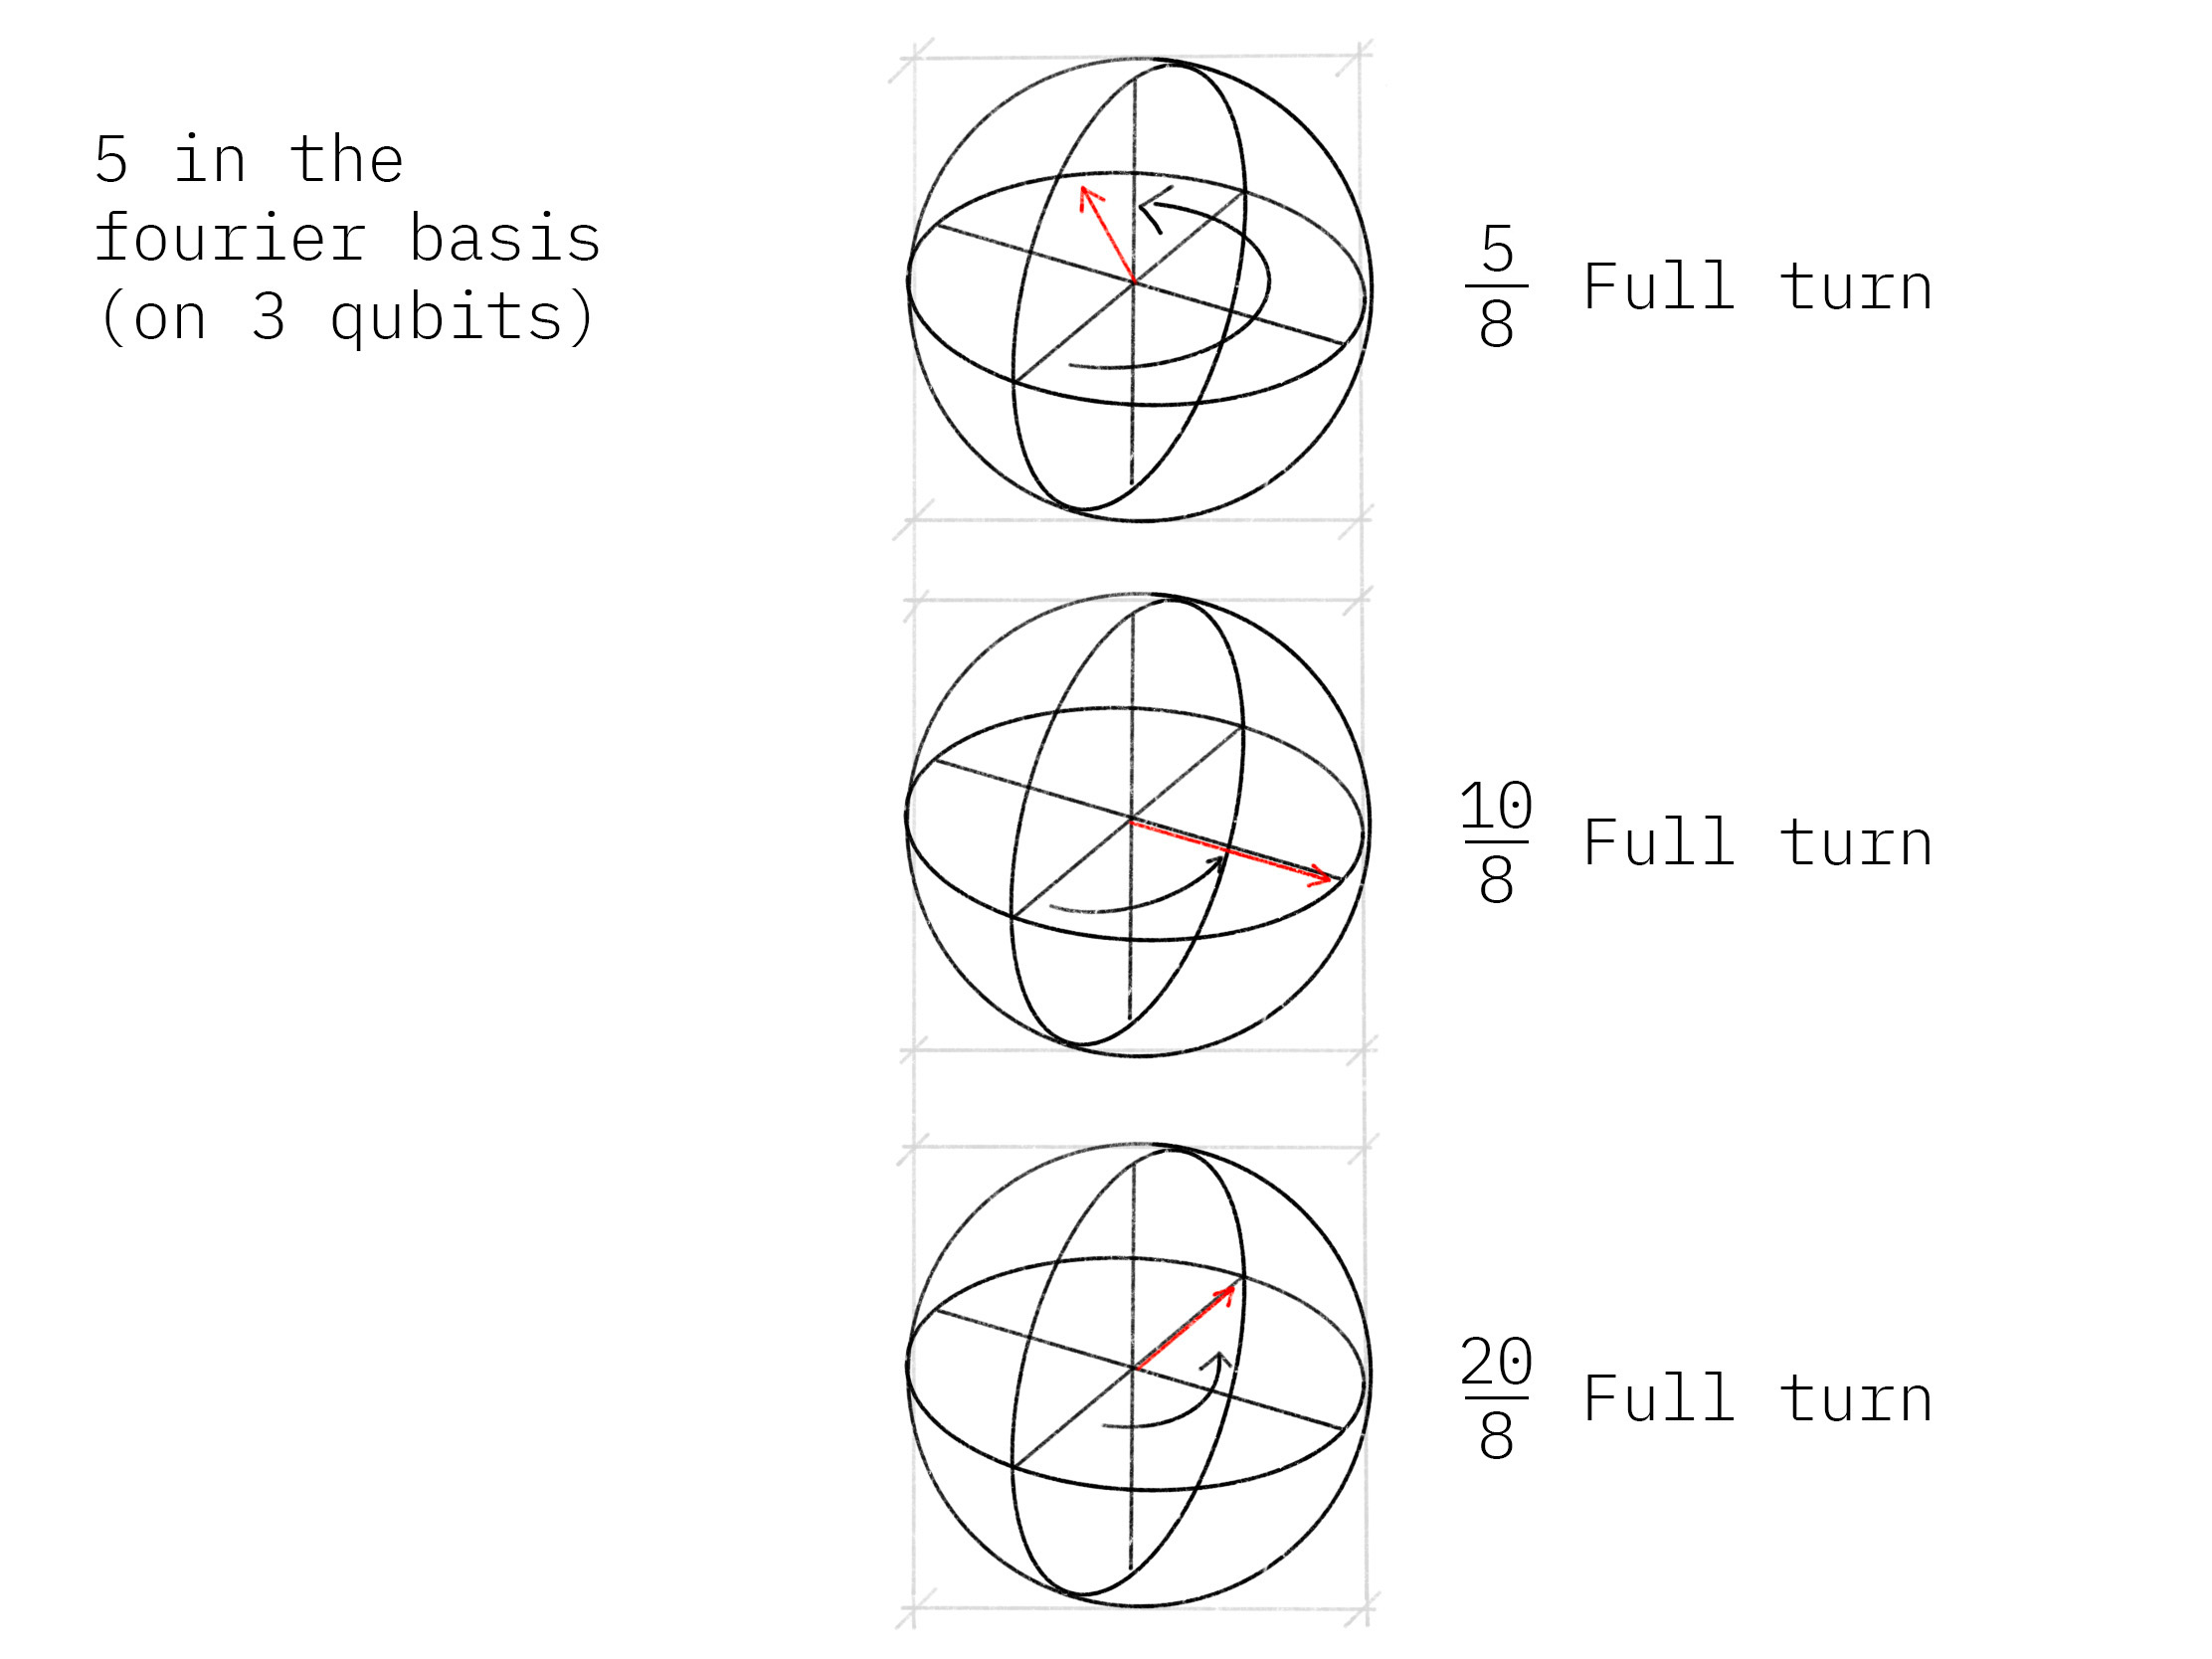

The first goal of QPE is to take the phase of $U$, and put it into the counting registers as a number between 0 and $2^t$ in the Fourier basis. Then we simply use $QFT^\dagger$ to convert this into the computational basis.  

For example, we would like to take a unitary that has an eigenvalue $U|\psi\rangle=e^{2\pi\theta i}|\psi\rangle$. By repeatedly performing controlled versions of U, we can encode the value of the phase in the counting register as the Fourier transform of a binary number $2^t\theta$ i.e. the counting register will be $|\tilde{2}^t\tilde{\theta}\rangle$. The final step is then to use the inverse QFT to put the counting registers into the state $|2^t\theta\rangle$.  By performing a measurement on this state, we discover the eigenvalue of the state $|\psi\rangle$


## The Math Behind the Curtain

As mentioned above, this circuit estimates the phase of a unitary operator $U$. It estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, where $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue.

i. **Setup**: $\vert\psi\rangle$ is in one set of qubit registers storing the quantum state whose eigenvalue we would like to learn. An additional set of $n$ qubits form the counting register on which we will store the value $2^n\theta$:



$$ \psi_0 = \lvert 0 \rangle^{\otimes n} \lvert \psi \rangle$$



ii. **Superposition**: Apply a $n$-bit Hadamard gate operation $H^{\otimes n}$ on the counting register:



$$ \psi_1 = {\frac {1}{2^{\frac {n}{2}}}}\left(|0\rangle +|1\rangle \right)^{\otimes n} \lvert \psi \rangle$$



iii. **Controlled Unitary Operations**: We need to introduce the controlled unitary $C-U$ that applies the unitary operator $U$ on the target register only if its corresponding control bit is $|1\rangle$. Since $U$ is a unitary operator with eigenvector $|\psi\rangle$ such that $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, this means:



$$U^{2^{j}}|\psi \rangle =U^{2^{j}-1}U|\psi \rangle =U^{2^{j}-1}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{j}\theta }|\psi \rangle$$



Applying all the $n$ controlled operations $C − U^{2^j}$ with $0\leq j\leq n-1$, and using the relation $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =\left(|0\rangle +e^{2\pi i\theta }|1\rangle \right)\otimes |\psi \rangle$:

\begin{aligned}
\psi_{2} & =\frac {1}{2^{\frac {n}{2}}} \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{n-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right) \otimes |\psi\rangle\\\\
& = \frac{1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \vert\psi\rangle
\end{aligned}
where $k$ denotes the integer representation of n-bit binary numbers.

iv. **Inverse Fourier Transform**: Notice that the above expression is exactly the result of applying a quantum Fourier transform i.e.

$$
QFT\vert x \rangle = \frac{1}{2^\frac{n}{2}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right)
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right)
$$

Replacing $x$ by $2^n\theta$ in the above expression gives exactly the expression derived in step 2 above. Therefore, to recover the state $\vert2^n\theta\rangle$, apply an inverse Fourier transform on the auxiliary register. Doing so, we find

$$
\vert\psi_3\rangle = \frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} \frac {1}{2^n}\sum _{x=0}^{2^{n}-1}\sum _{k=0}^{2^{n}-1} e^{-\frac{2\pi i k}{2^n}(x - 2^n \theta)} |x\rangle \otimes |\psi\rangle
$$

v. **Measurement**:
The above expression peaks near $x = 2^n\theta$. For the case when $2^n\theta$ is an integer, measuring in the computational basis gives the phase in the auxiliary register with high probability:



$$ |\psi_4\rangle = | 2^n \theta \rangle \otimes | \psi \rangle$$



For the case when $2^n\theta$ is not an integer, it can be shown that the above expression still peaks near $x = 2^n\theta$ with probability better than $4/\pi^2 \approx 40\%$.

## Coding QPE for the T-gate

Let’s take a gate we have passing familar with, the $T$-gate, and use Quantum Phase Estimation to estimate its phase. $T$-gate adds a phase of $e^\frac{i\pi}{4}$ to the state $|1\rangle$:

$$ T|1\rangle =
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\
\end{bmatrix}
\begin{bmatrix}
0\\
1\\
\end{bmatrix}
= e^\frac{i\pi}{4}|1\rangle $$

Since QPE will give us $\theta$ where:



$$ T|1\rangle = e^{2i\pi\theta}|1\rangle $$



We expect to find:



$$\theta = \frac{1}{8}$$



In this example we will use three qubits in the counting register and obtain an _exact_ result (not an estimate!) because 8 is a power of 2.

Step 1: Preparing the environment

* Import `numpy` as `np`, `math`, `QuantumCircuit`, `GenericBackendV2`, `AerSimulator`, and `plot_histogram`
* Then, import some new things to do more advanced sims

In [3]:
#initialization
import numpy as np
import math

# importing Qiskit
from qiskit.circuit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

#importing more advanced thing
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeNairobiV2

Now, set up the quantum circuit. We will use four qubits -- qubits 0 to 2 as counting qubits, and qubit 3 as $|\psi\rangle$, the eigenstate of $T$.  There are two eigenstates we could choose, $|0\rangle$ or $|1\rangle$. $|0\rangle$ has $\theta=0$ and isn't terribly interesting.  $|1\rangle$ has $\theta=\frac{1}{8}$ and is more interesting.  So let's initialize $\vert\psi\rangle = \vert1\rangle$

gate: 0
qubit: 0
gate: 0
qubit: 1
gate: 1
qubit: 1
gate: 0
qubit: 2
gate: 1
qubit: 2
gate: 2
qubit: 2
gate: 3
qubit: 2


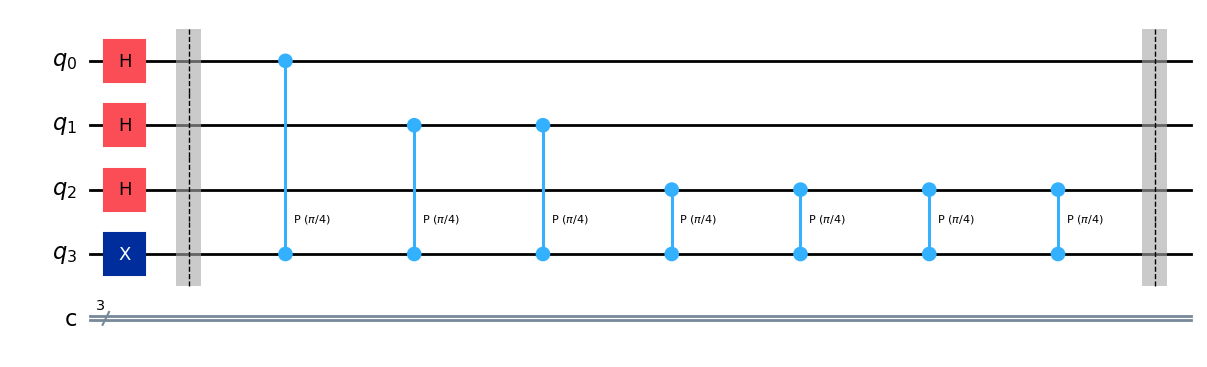

In [21]:
#Prepare a quantum circuit called `qpe` with 4 qubits and 3 classical bits
qpe = QuantumCircuit(4,3)

#We want to prepare the final qubit, q3 into a |1> state
qpe.x(3)

# Make a for loop over the 3 counting qubits and within it, apply a H gate
for i in range(3):
  qpe.h(i)

qpe.barrier()
#Lets draw the circuit to check ourselves
repetitions = 1
for qubit in range (3):
    for gates in range(0, repetitions):
        print(f'gate: {gates}')
        print(f"qubit: {qubit}")
        qpe.cp(np.pi/4, qubit, 3)
    repetitions *= 2

qpe.barrier()
qpe.draw('mpl')

0
1


Next, for every counting qubit, we want to apply a Hadamard gate:

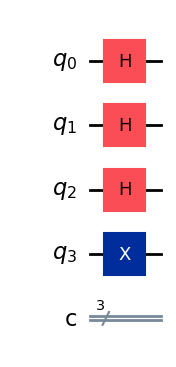

Next we perform the controlled unitary operations. **Remember:** Qiskit orders its qubits the opposite way round to the image above.

As discussed, we want to apply C-U to q3 controlled on q0 , C-U^2 to q3 controlled on q1, U^4 to q3 controlled on q2.  One way to do this, which could be modified to counting registers of differing length is to employ a for loop.  One possible pseudocode might be:

    repetitions = 1
    FOR qubit from 0 to 2
        FOR gates from 0 to repetitions
            APPLY Controlled-P gate with pi/4 controlled on qubit to q3
        repetitions *= 2
        
 I forget if we have introduced the controlled phase gate in QISKIT, so lets do it now:
     
     circuit.cp(theta,control_qubit,target_qubit)

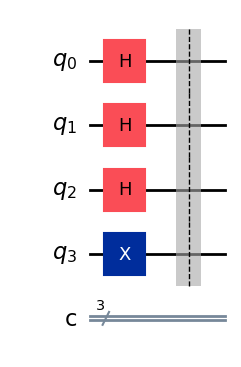

In [7]:

qpe.draw('mpl')

We apply the inverse quantum Fourier transformation to convert the state of the counting register. In the previous lab, you made a recursive verion of the QFT and performed a inverse operation onto it.  Here, lets code up directly the inverse QFT.

In [14]:
#Lets define a function qft_dagger that takes in a circuit `qc` and the number of qubits `n`
def qft_dagger(qc, n):
    # We need a for loop over qubit from 0 to n/2 (remember to use the integer division //)
    for qubit in range(n//2):
        #Inside this loop, we want to swap the qubits indexed at `qubit` and `n-qubit-1`
        qc.swap(qubit, n-qubit-1)
    # Now we need a for loop over and integer j in range(n)
    for j in range(n):
        #and within this, a for loop over m in the range(j)
        for m in range(j):
            #Here we need a controlled-phase gate with theta=-math.pi/float(2**(j-m)),
            #controlled by m and targetting j
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        #Outside the m loop, but within the j loop, we need to add H gates to each qubit
        qc.h(j)

With this function defined we need to apply it to our circuit, and then measure all the counting registers.  In order to make sure this code is properly sequenced, we want to introduce the `circuit.barrier()` function.  This function ensures that the transpiler doesn't try to combine code across it.

For measuring, if we want to place the result of measuring `qubit` into `classical_bit` we use the syntax:
    
    circuit.measure(qubit,classical_bit)

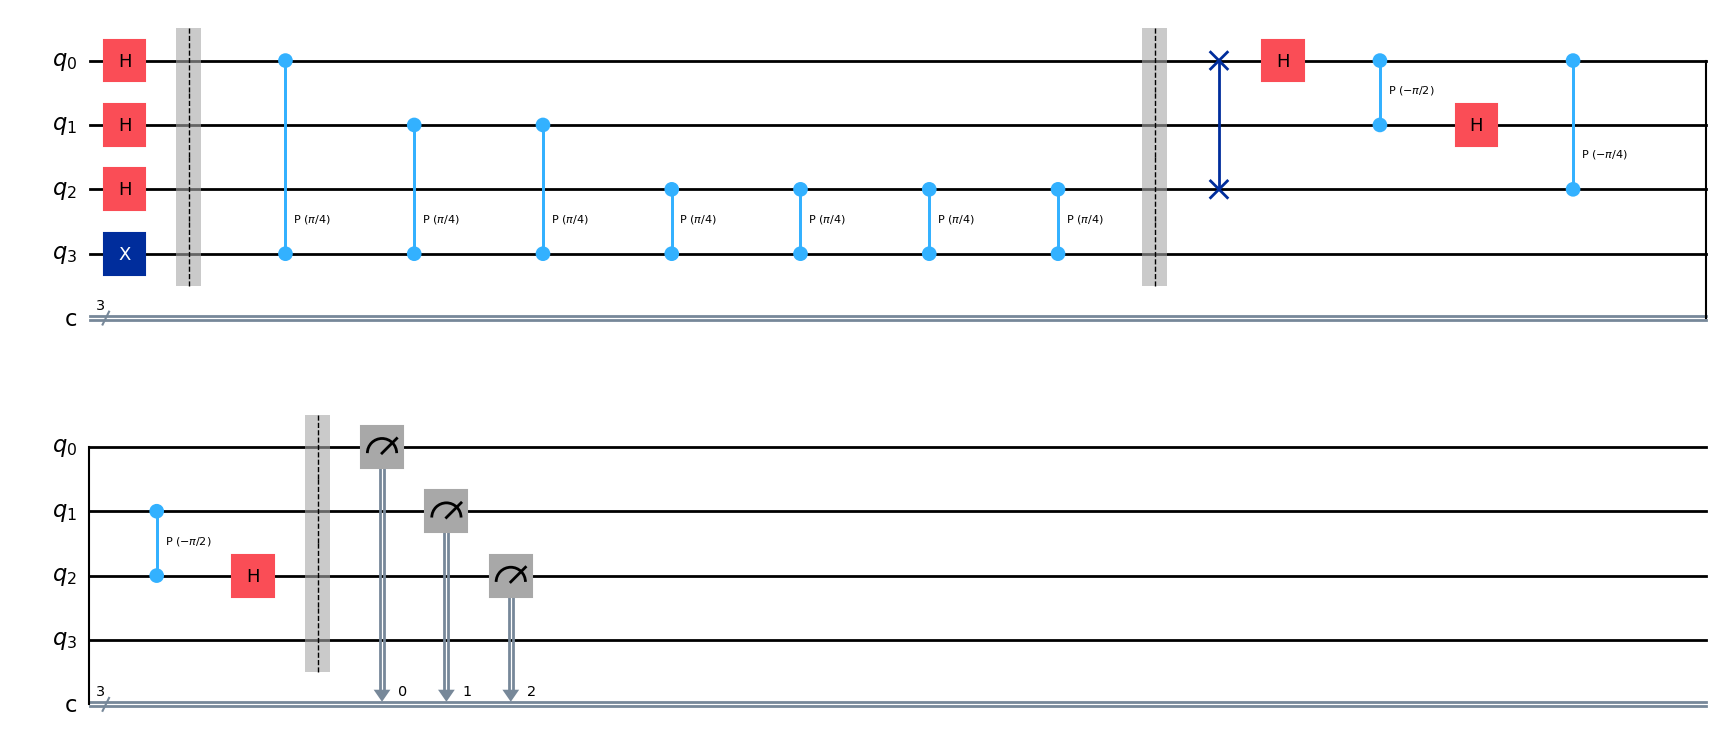

In [45]:
#Prepare a quantum circuit called `qpe` with 4 qubits and 3 classical bits
qpe = QuantumCircuit(4,3)

#We want to prepare the final qubit, q3 into a |1> state
qpe.x(3)

# Make a for loop over the 3 counting qubits and within it, apply a H gate
for i in range(3):
  qpe.h(i)

qpe.barrier()
#Lets draw the circuit to check ourselves

repetitions = 1
for qubit in range (3):
    for gates in range(0, repetitions):
        qpe.cp(np.pi/4, qubit, 3)
    repetitions *= 2

qpe.barrier()
#apply a barrier to your circuit qpe

# Apply inverse QFT for the circuit with n=3
qft_dagger(qpe, 3)
#apply another barrier
qpe.barrier()
# Make a for loop over the range(3) and measure each of the counting register qubits
for i in range(3):
  qpe.measure(i,i)

#Last but not least, lets draw the circuit to compare to the cartoon above
qpe.draw('mpl')


Now we can finish up by running this with the aer_simulator.

<ipython-input-23-355571422361>:11: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend, options=options)


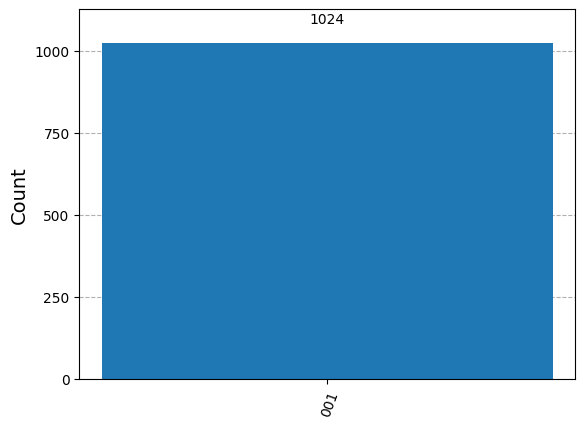

In [23]:
#define a backend using AerSimulator()
backend = AerSimulator()

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
transpiled_circuit = pm.run(qpe)

# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 22}}

#Set up the Sampler simulater backend
sampler = Sampler(backend=backend, options=options)

#Run the circuits, and get results
result = sampler.run([transpiled_circuit]).result()

#Plot the result.  Now what is this madness?  this says, from results, pull the first element, which stores important data and info
#Then pulls the data itself, and c is the default name of the measured classical bits when you don't specify their name in the Quantum Circuit
plot_histogram(result[0].data.c.get_counts())

If all has gone according to plan, you got `001` with 100% certainty, which translates to the decimal: `1`. We need to divide our result (`1`) by $2^n$ to get $\theta$:

In [24]:
#Put you most likely result from running the code in the binary_answer variable as a string
binary_answer= '001'

#This code converts your binary representation to a decimal representation
decimal_answer=int(binary_answer,2)

#Store the number of counting qubits in the register
number_of_counting_qubits=3

#Compute theta
theta=decimal_answer/2**number_of_counting_qubits

#Print theta
print("Experimental Theta: ", theta)
print("Exact Theta: ", 1/8)


Experimental Theta:  0.125
Exact Theta:  0.125


## Getting More Precision

The $T$-gate was special, because the exact answer could be reached with a specific number of qubits. Now, let's use a gate with $\theta = \frac{1}{3}$ which cannot be exactly represented in binary notation. We set up our circuit following your previous work, much of which can be copied down. <b>But be careful, copying code is an amazing way to introduce errors when difference in the code aren't appreciated</b>

<b> Importantly, don't name the circuit the same name.  Instead call it `qpe2` </b>

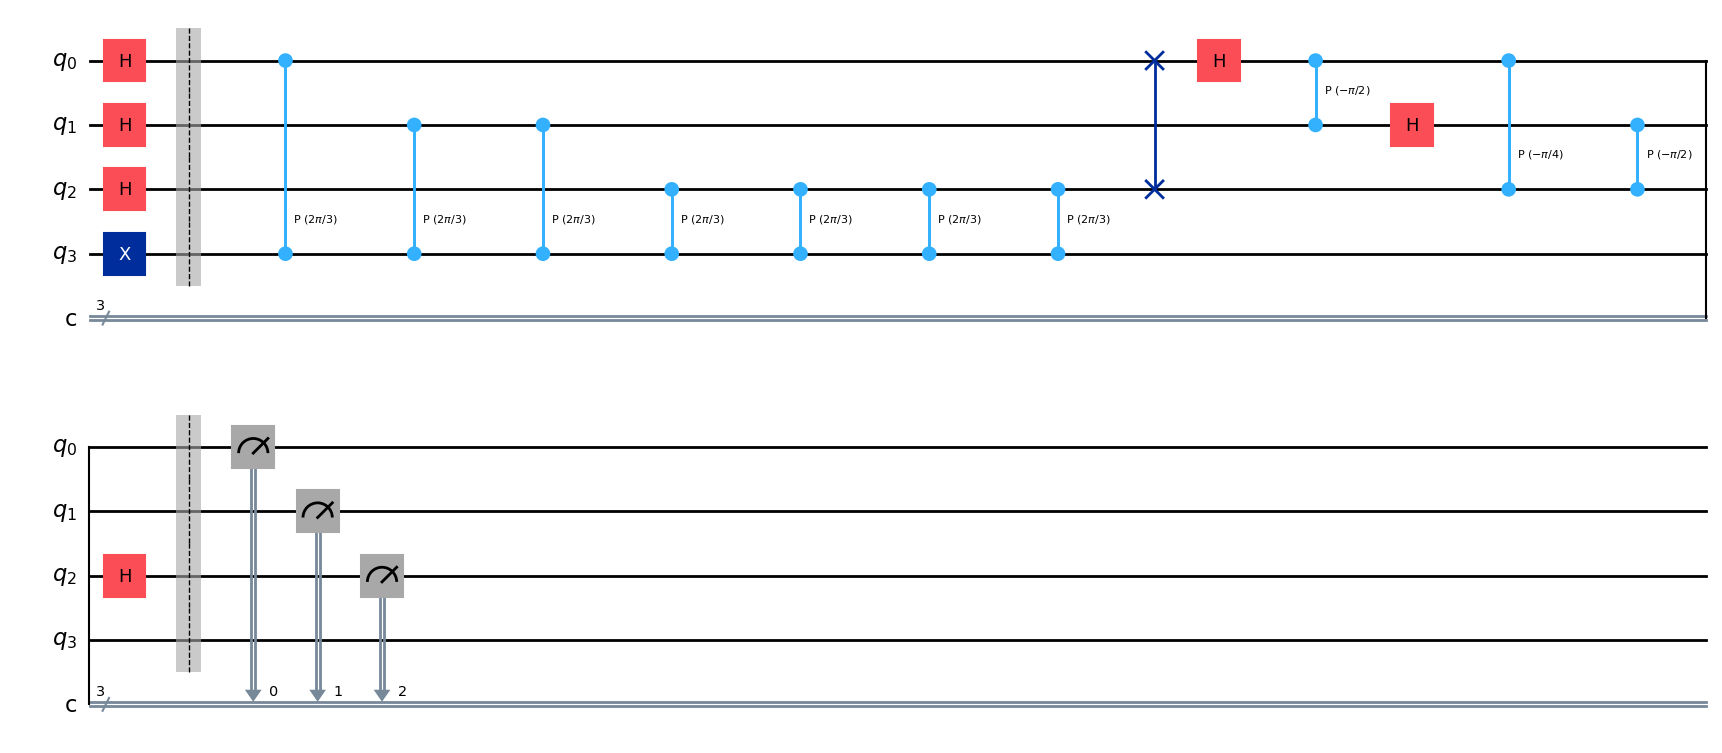

In [52]:
# Create and set up circuit with 4 qubits and 3 classical bits
qpe2 = QuantumCircuit(4,3)

# Apply H-Gates to counting qubits through a for loop:
for i in range(3):
  qpe2.h(i)

# Prepare our eigenstate |psi>=|1> on the last qubit:
qpe2.x(3)

# Do the controlled-U operations:
qpe2.barrier()
#First, we want to define a variable `angle` which we will store 2*theta that we want
#In this case, we want theta=pi/3
theta = np.pi/3
angle = 2*theta

#Here we want to introduce the code that will perform controlled phase gates controlled by the
#counting registers.  For the angle argument of circuit.cp() we want to use `angle`
repetitions = 1
for qubit in range (3):
    for gates in range(0, repetitions):
        qpe2.cp(angle, qubit, 3)
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe2, 3)

#Add a barrier
qpe2.barrier()

# Finish with a measurement, storing each of your counting register qubits into a classical one
for i in range(3):
  qpe2.measure(i, i)

#For sanity, better draw the circuit
qpe2.draw('mpl')

<ipython-input-53-c98ae9cf5a78>:11: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend, options=options)


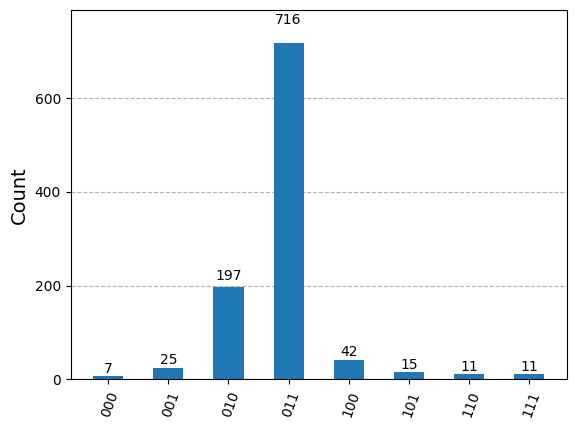

In [53]:
# Let's see the results!
backend = AerSimulator()

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
transpiled_circuit = pm.run(qpe2)

# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}

#Set up the Sampler simulater backend
sampler = Sampler(backend=backend, options=options)

#Run the circuits, and get results
result = sampler.run([transpiled_circuit]).result()

#Plot the result
plot_histogram(result[0].data.c.get_counts())

Congrats, you have some results.  For reasons unknown to me, in the Sampler they output the decimal representations of your qubit states.  So for example $|4\rangle = |100\rangle$ in binary.  So don't freak out -- just yet.

We are expecting the result $\theta = 0.3333\dots$, lets check.  If you have multiple, largish results, use the next cell on both.  In such cases, the two should be considered bounds on the right answer.  

In [54]:
#Put you most likely result from running the code in the binary_answer variable as a string
binary_answer='011'

#Cover to a decimal number
decimal_answer=int(binary_answer,2)

#Store the number of counting qubits in the register
number_of_counting_qubits=3

#Compute theta
theta=decimal_answer/2**number_of_counting_qubits

#Print theta
print("Experimental Theta: ", theta)
print("Exact Theta: ", 1/3)


Experimental Theta:  0.375
Exact Theta:  0.3333333333333333


I suspect you found two most likely results, `010(bin) = 2(dec)` and `011(bin) = 3(dec)`. These correspond to $\theta = 0.25$ (off by 25%) and $\theta = 0.375$ (off by 13%) respectively. The true value, though, does lies between the values we can get from our counting bits, and this gives us a measure of uncertainty and imprecision.

The failure to get a good precision is that our range of possible results is finite, and limited by how many qubits we put into our counting register.  Consider the the possible values of $\theta$ when we have 3,4, or 5 qubits:

In [28]:
for n in range(3,6):
    theta_array=np.zeros(2**n)
    for i in range(0,2**n):
        theta_array[i]=i/2**n
    print("n=",n,"\n options for theta: \n",theta_array)

n= 3 
 options for theta: 
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875]
n= 4 
 options for theta: 
 [0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625
 0.625  0.6875 0.75   0.8125 0.875  0.9375]
n= 5 
 options for theta: 
 [0.      0.03125 0.0625  0.09375 0.125   0.15625 0.1875  0.21875 0.25
 0.28125 0.3125  0.34375 0.375   0.40625 0.4375  0.46875 0.5     0.53125
 0.5625  0.59375 0.625   0.65625 0.6875  0.71875 0.75    0.78125 0.8125
 0.84375 0.875   0.90625 0.9375  0.96875]


Notice how as we add more qubits, we get a finer and finer resolution on the decimial values.
To get more precision, therefore, we can add more counting qubits! For this example, let's add 2 more qubits.

To do this, you could just repeat the code from about, except with 6 qubits and 5 classical bits.

<b>Again though, don't name the circuit the same thing, call it `qpe3`</b>

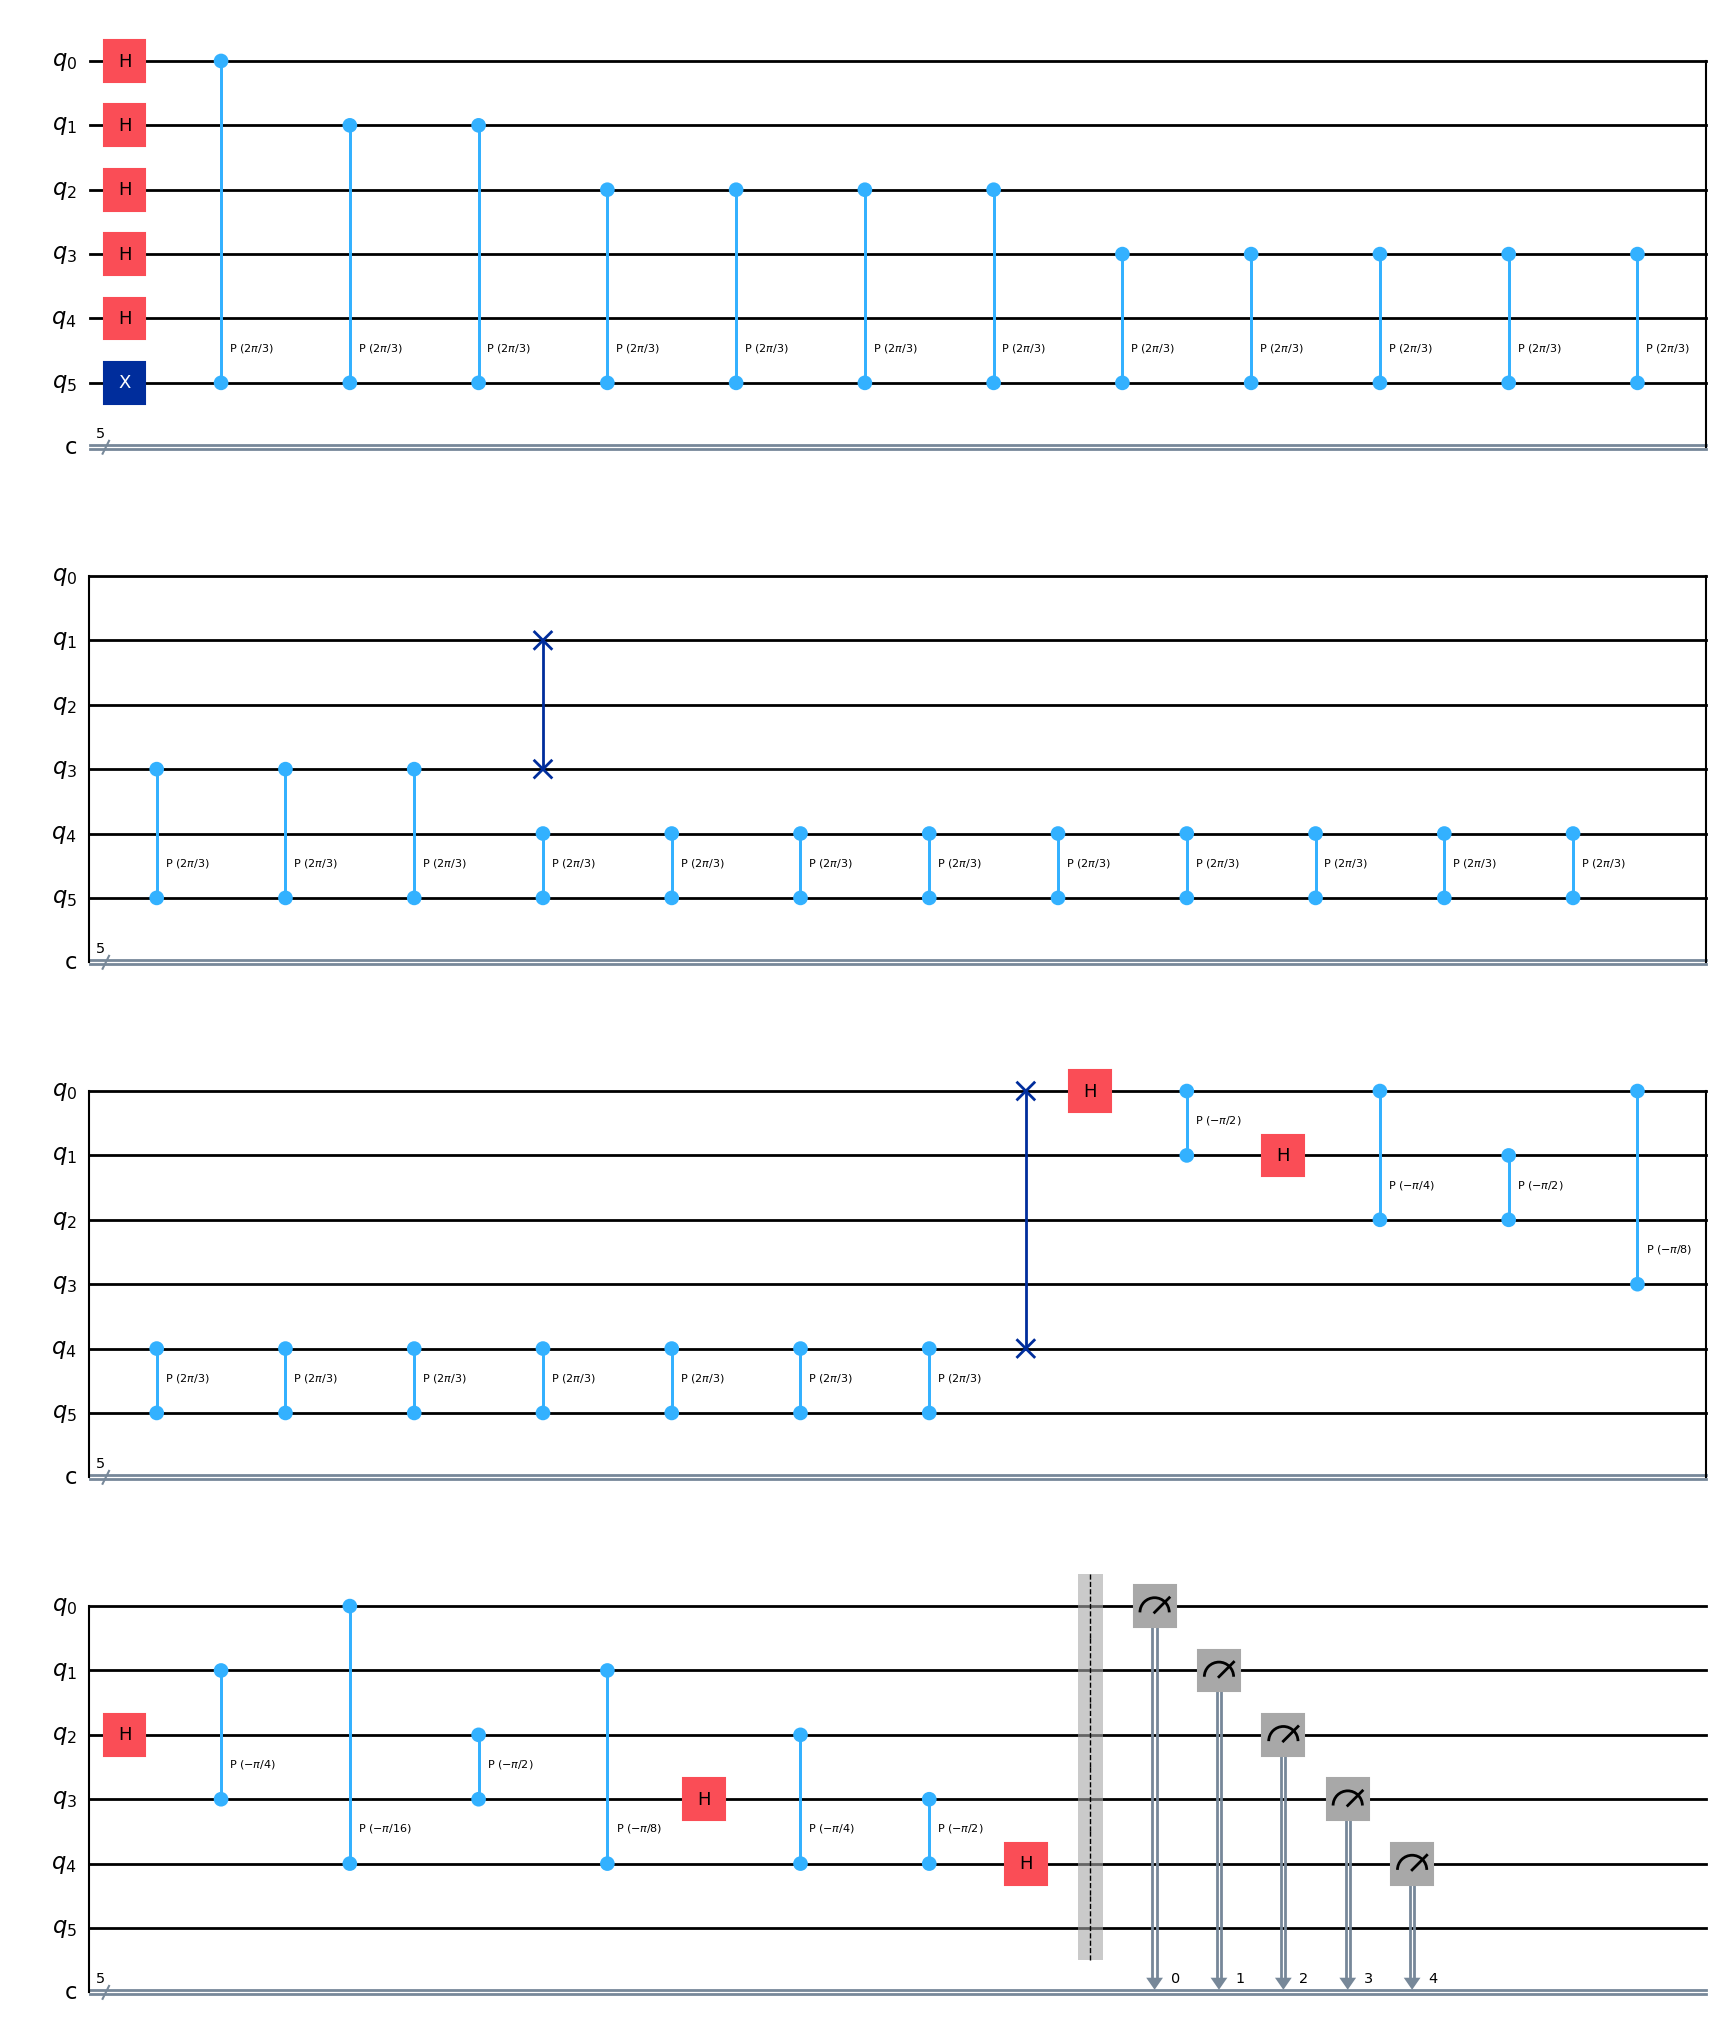

In [50]:
# Create and set up circuit with 4 qubits and 3 classical bits
qpe3 = QuantumCircuit(6,5)

# Apply H-Gates to counting qubits through a for loop:
for i in range(5):
  qpe3.h(i)

# Prepare our eigenstate |psi>=|1> on the last qubit:
qpe3.x(5)

# Do the controlled-U operations:
qpe2.barrier()
#First, we want to define a variable `angle` which we will store 2*theta that we want
#In this case, we want theta=pi/3
theta = np.pi/3
angle = 2*theta

#Here we want to introduce the code that will perform controlled phase gates controlled by the
#counting registers.  For the angle argument of circuit.cp() we want to use `angle`
repetitions = 1
for qubit in range (5):
    for gates in range(0, repetitions):
        qpe3.cp(angle, qubit, 5)
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe3, 5)

#Add a barrier
qpe3.barrier()

# Finish with a measurement, storing each of your counting register qubits into a classical one
for i in range(5):
  qpe3.measure(i, i)

#For sanity, better draw the circuit
qpe3.draw('mpl')

<ipython-input-49-b56ff16efa61>:12: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend, options=options)


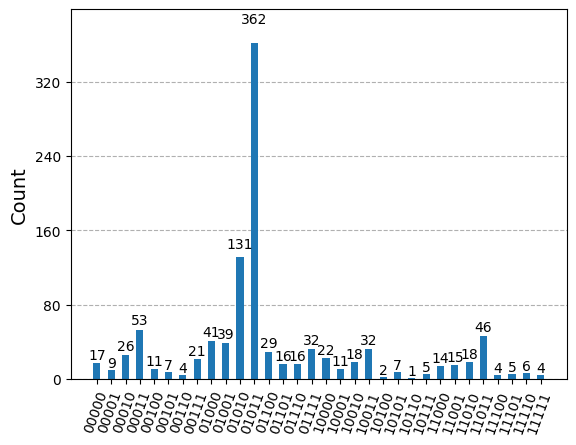

In [49]:
# Let's see the results!
#Transpile
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
transpiled_circuit = pm.run(qpe3)

# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 22}}

#Set up the Sampler simulater backend
sampler = Sampler(backend=backend, options=options)

#Run the circuits, and get results
result = sampler.run([transpiled_circuit]).result()

#Plot the result
plot_histogram(result[0].data.c.get_counts())

Take your two most common results, and put them into the cell below.  And compare to how you with the lower resolution results of before

In [39]:
#Put you most likely results from running the code in the binary_answer1 and binary_string2 variables as a string
binary_answer1='01010'
binary_answer2='01011'

#Cover to a decimal number
decimal_answer1=int(binary_answer1,2)
decimal_answer2=int(binary_answer2,2)

#Store the number of counting qubits in the register
number_of_counting_qubits=5

#Compute theta
theta1=decimal_answer1/2**number_of_counting_qubits
theta2=decimal_answer2/2**number_of_counting_qubits

#Print theta
print("Experimental Theta Bound: ", theta1)
print("Experimental Theta Bound: ", theta2)
print("Exact Theta: ", 1/3)


Experimental Theta Bound:  0.3125
Experimental Theta Bound:  0.34375
Exact Theta:  0.3333333333333333


If everything went to plan, you should have found the new results differ from $\frac{1}{3}$ by about 5%.  <b>A much better result than about 20% errors of before!</b>

## What does it look like with noise <a id='real_devices'></a>

Let's start with trying to see how running on a machine effects `qpe` which is our $T$ gate example.  First, lets check that it is still properly stored:

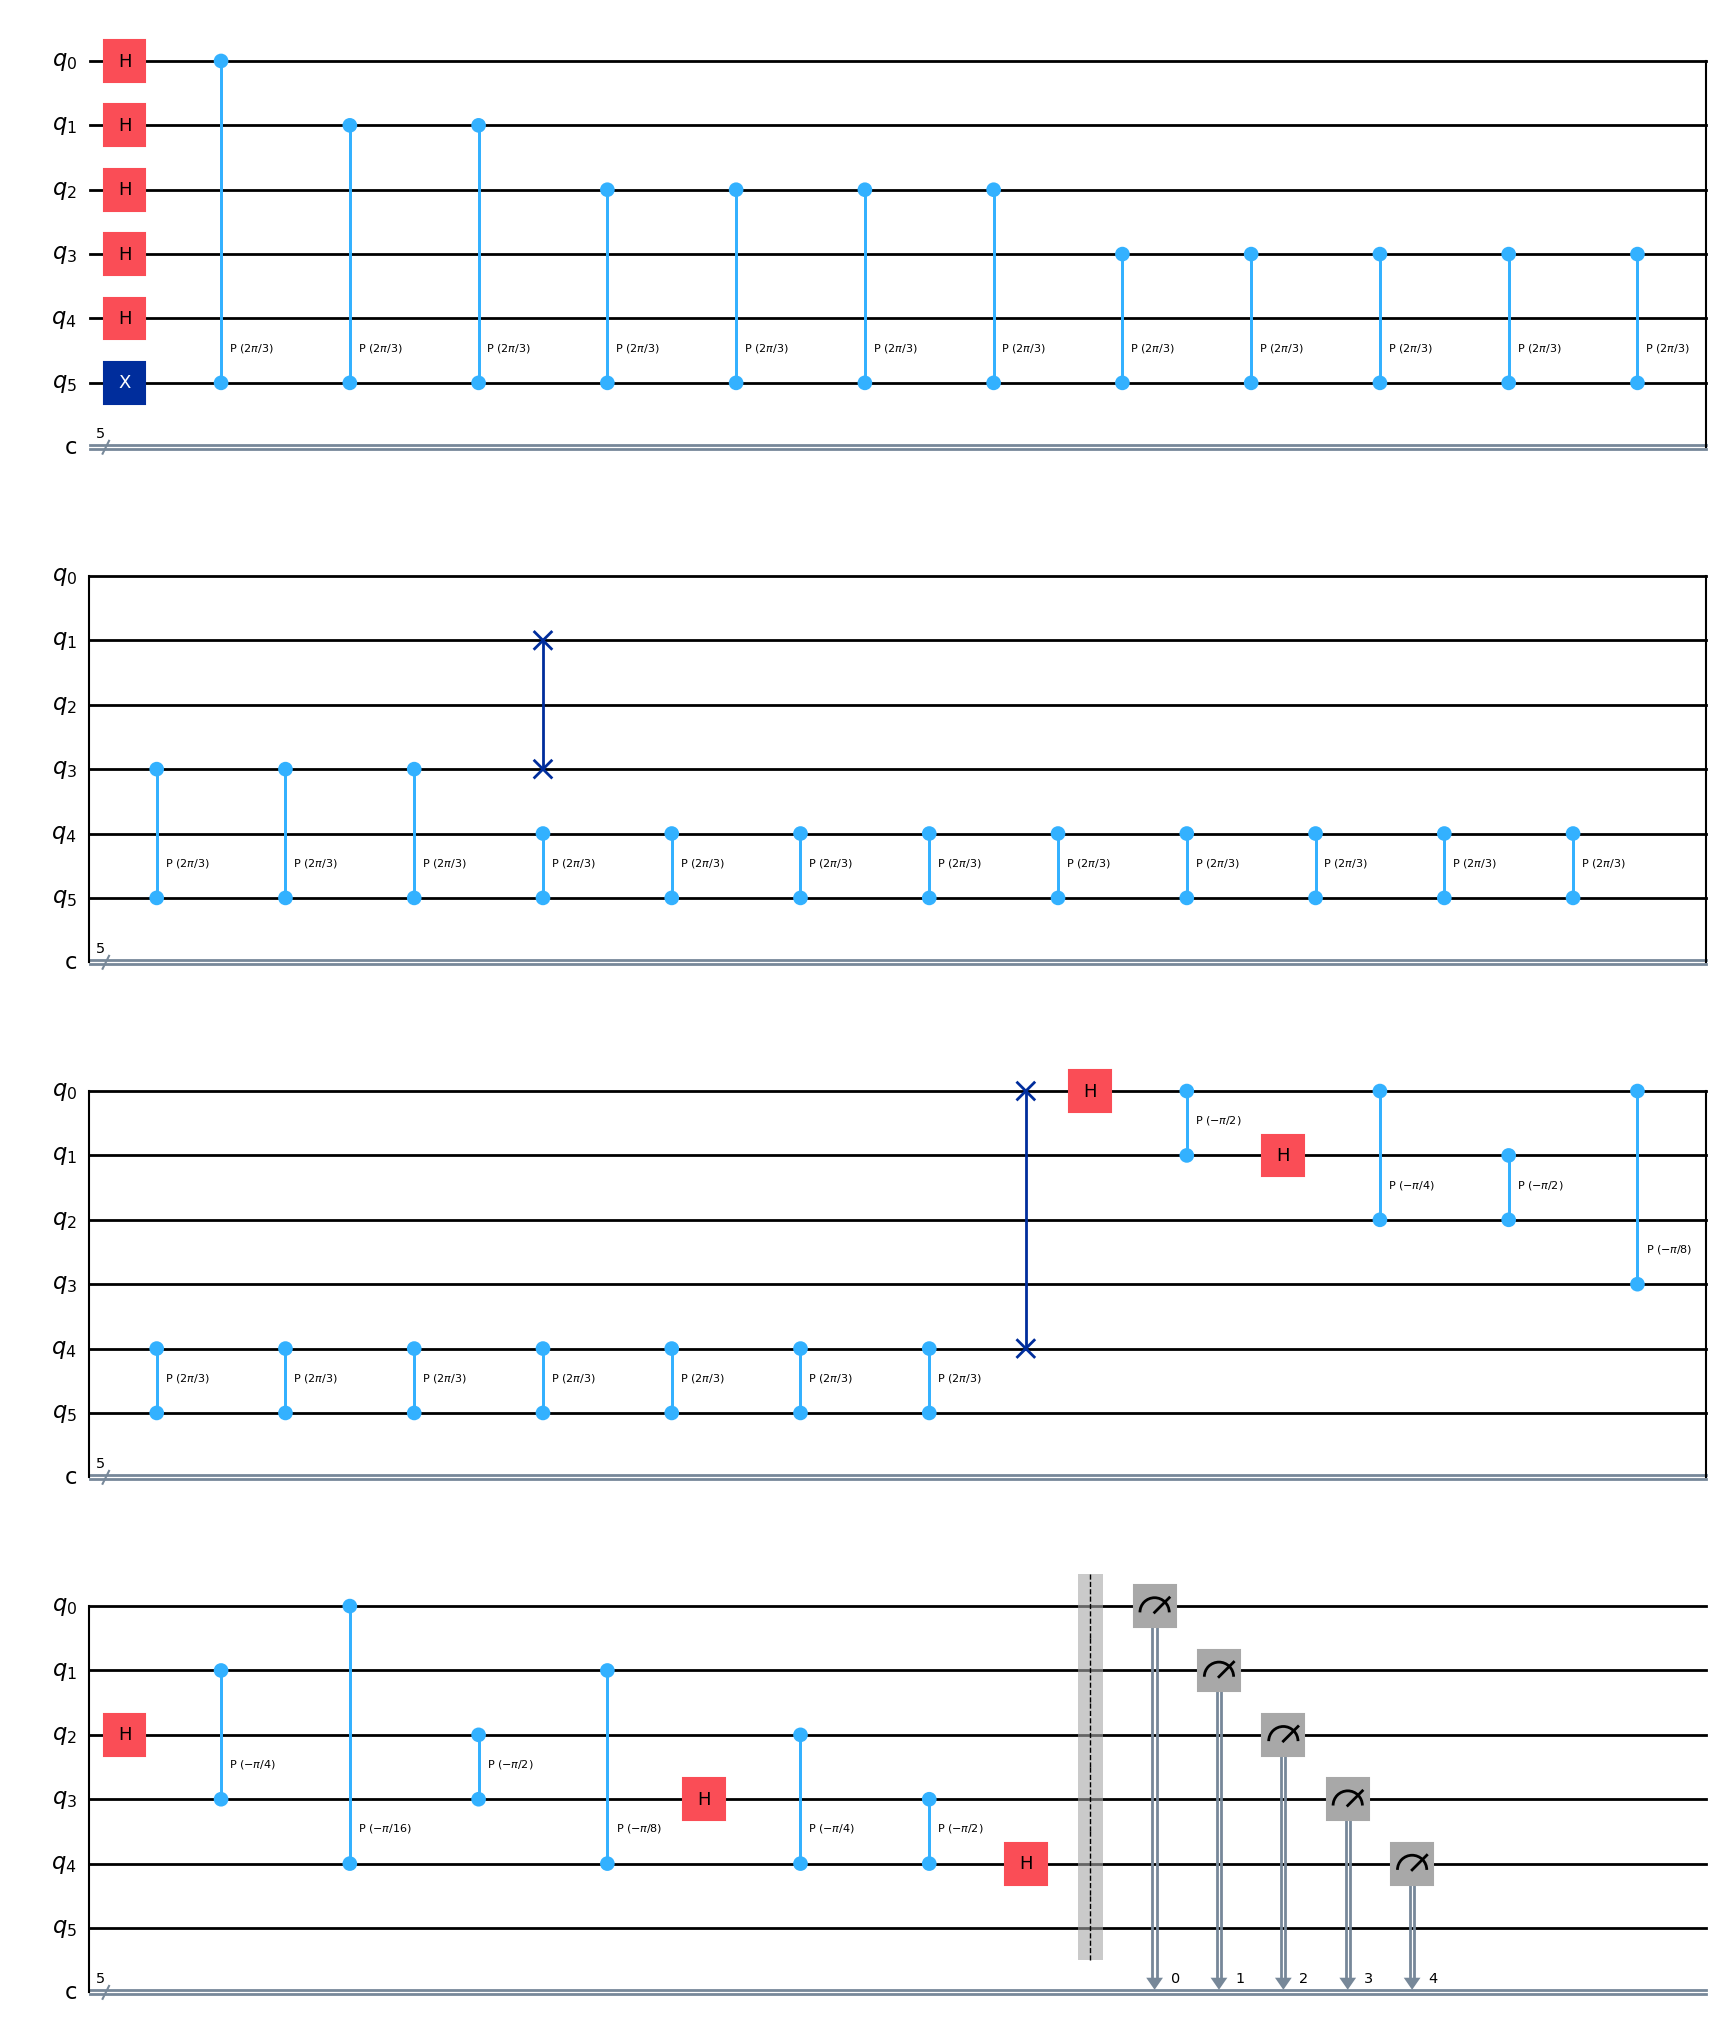

In [43]:
#Draw qpe.  Does it still agree with what you have above?
qpe3.draw('mpl')

<ipython-input-44-d67410aeca64>:10: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend, options=options)


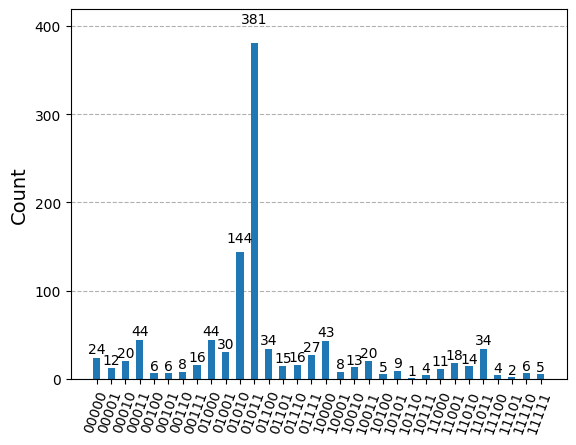

In [44]:
# Run the sampler job locally using FakeNairobiV2
backend = FakeNairobiV2()
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
transpiled_circuit = pm.run(qpe3)

# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 22}}

#Set up the Sampler simulater backend
sampler = Sampler(backend=backend, options=options)

#Run the circuits, and get results
result = sampler.run([transpiled_circuit]).result()

#Plot the result
plot_histogram(result[0].data.c.get_counts())

We can hopefully see that the most likely result is `001` which is the result we would expect from the simulator. Unlike the simulator, there is a probability of measuring something other than `001`, this is due to noise and gate errors in the quantum computer.

Now, how about we be more try the more ambitious `qpe3`  Repeat the code in the previous couple of code cells, but with the `qpe3`.